# Sentiment analysis using Google's trained word2vec




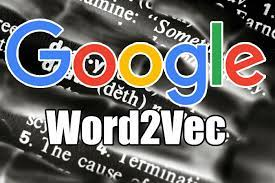

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 42.2MB/s]


In [43]:
!kaggle datasets download -d sandreds/googlenewsvectorsnegative300

100% 1.64G/1.64G [00:17<00:00, 89.6MB/s]
100% 1.64G/1.64G [00:17<00:00, 102MB/s] 


In [44]:
!unzip "googlenewsvectorsnegative300.zip"

Archive:  googlenewsvectorsnegative300.zip
  inflating: GoogleNews-vectors-negative300.bin  


In [5]:
!unzip "twitter-airline-sentiment.zip"

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


## About the data set 
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Import the libraries

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from string import punctuation
import pickle , re
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.utils import shuffle

## Read Data set

In [32]:
data = pd.read_csv('Tweets.csv')

In [33]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [34]:
data.shape

(14640, 15)

In [35]:
sentiment_counts = data.airline_sentiment.value_counts()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [36]:
number_of_tweets = data.tweet_id.count()
print(number_of_tweets)

14640


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


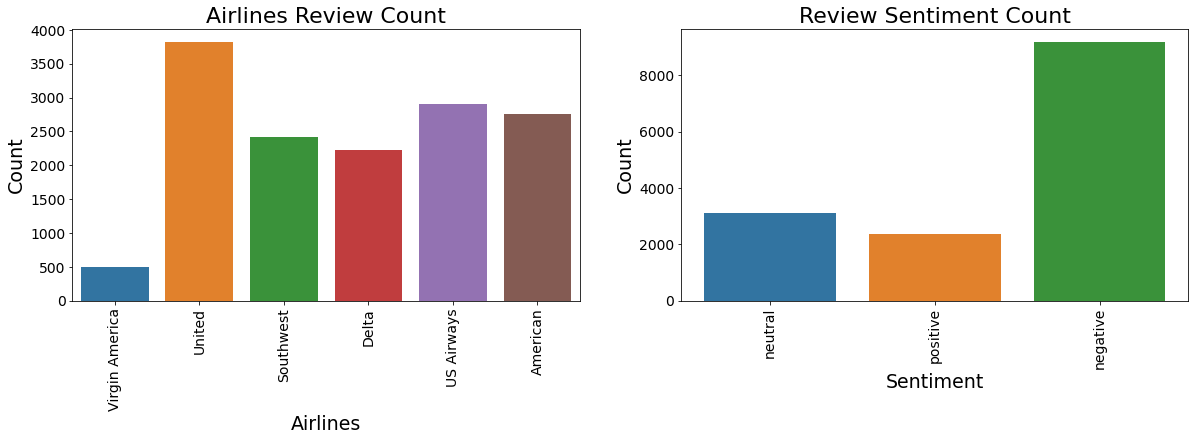

In [37]:
figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

plt.subplot(121)
col = "airline"
xlabel = "Airlines"
ylabel = "Count"

sns.countplot(x=data[col])
plt.title("Airlines Review Count")
plt.xticks(rotation=90)
plt.xlabel(xlabel)
plt.ylabel(ylabel)


plt.subplot(122)
col = "airline_sentiment"
xlabel = "Sentiment"
ylabel = "Count"
sns.countplot(data[col])
plt.title("Review Sentiment Count")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()
plt.show()

objervations:
Most of the review present here are negative.
Highest number of tweets are about "United Airlines", "US Airlines" and "American Airlines"

[]

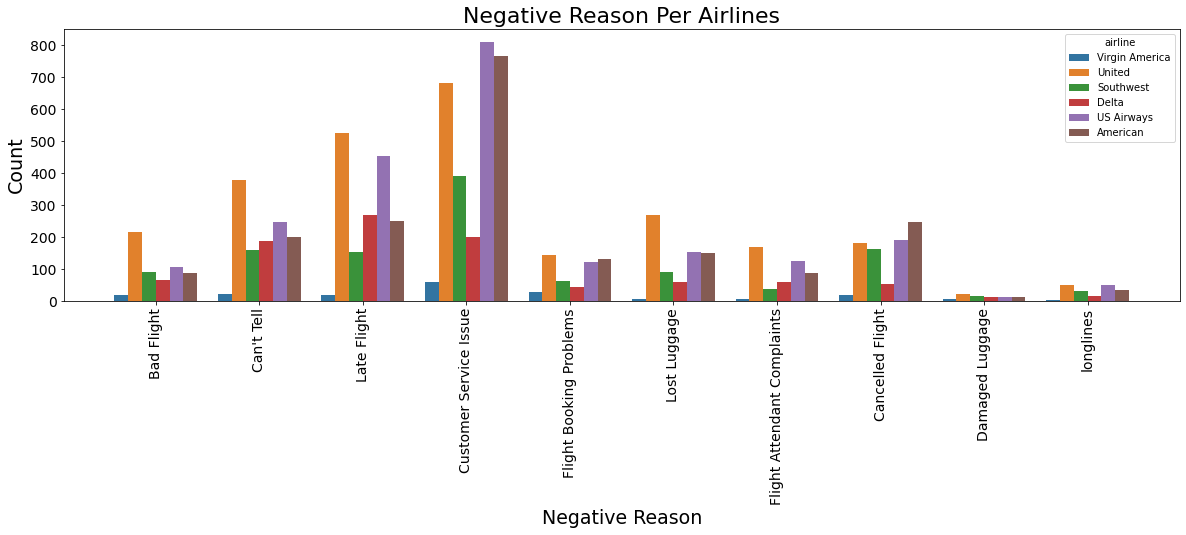

In [38]:
figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Negative Reason"
ylabel = "Count"

title = "Negative Reason Per Airlines"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "negativereason"
col2 = "airline"
sns.countplot(x=data[col1], hue=data[col2])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()


Most of the negative tweets are about "Customer Service Issue".

[]

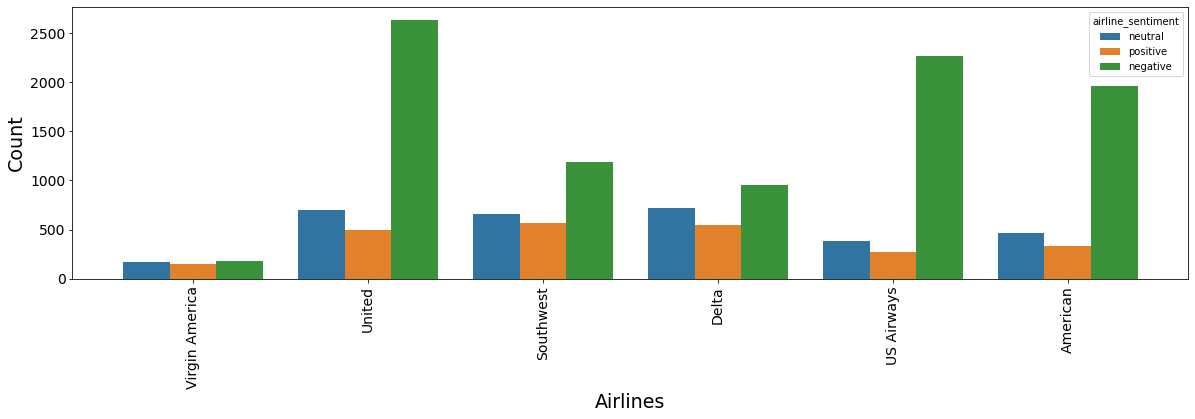

In [39]:
figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Airlines"
ylabel = "Count"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

plt.figure(figsize=figsize)
col1 = "airline"
col2 = "airline_sentiment"
sns.countplot(x=data[col1], hue=data[col2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

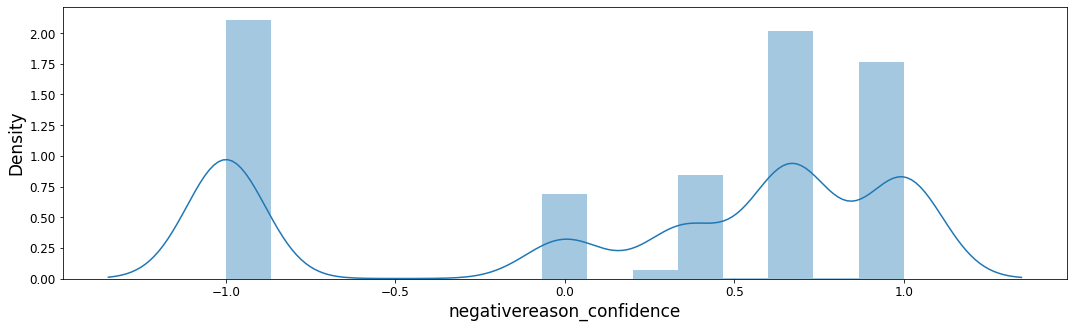

In [40]:
x = data["negativereason_confidence"].fillna(-1)

figsize=(18, 5)

ticksize = 12
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)
sns.distplot(x)
plt.plot()

## over-sampling

In [41]:
df_class_0 = data[data['airline_sentiment'] == 'negative']
df_class_1 = data[data['airline_sentiment'] == 'positive']
df_class_2 = data[data['airline_sentiment'] == 'neutral']
target_count = data.airline_sentiment.value_counts()
    
print(target_count[0] , target_count[1] , target_count[2])
df_class_1_over = df_class_1.sample(target_count[0], replace=True)
df_class_2_over = df_class_2.sample(target_count[0], replace=True)


df_test_over_total = pd.concat([df_class_0,df_class_1_over, df_class_2_over ], axis=0)

9178 3099 2363


In [42]:
print('Random over-sampling:')
print(df_test_over_total.airline_sentiment.value_counts())

Random over-sampling:
neutral     9178
negative    9178
positive    9178
Name: airline_sentiment, dtype: int64


## Word2vec

In [45]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True )

In [46]:
word_vectors = model.wv

def sentenceEmbedding(tokens):
    vectors=[]
    for word in tokens:
        if word not in word_vectors.vocab:
            vectors.append([0]*300) #size of feature vector
        else:
            vectors.append(model[word])
    
    result=[0] * len(vectors[0])
    res=0
    for i in range(len(vectors[0])):
         for vec in vectors:
                res+=vec[i]
         result[i]=(res/(len(tokens)))
         res=0
         
    return result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


## label Transformations

In [47]:
def mapSentiment(airlineSentiment):
    if airlineSentiment == 'positive':
        return 1
    elif airlineSentiment == 'negative' :
        return 0
    else:
        return 2

## Data Cleaning

In [48]:
wordnet_lemmatizer = WordNetLemmatizer()
def cleanString(sentences):
    result=[]
    for sen in sentences:
        s=""
        r=""
        s+=(sen.lower()+' ')
        s = re.sub("(@\w* )", ' ', s)
        s = re.sub("\\bhttps://(.*) \\b",' ',s) 
        s = re.sub("[^a-z0-9\ ]+", ' ', s)
        s = re.sub(' \d+', ' ', s)
        s = re.sub(" +",' ',s)
        tokens=s.split()
        for w in tokens:
             r+=wordnet_lemmatizer.lemmatize(w ,pos="v")+" "
        result.append(r)
    return result

In [50]:
review=df_test_over_total.text
label=df_test_over_total.airline_sentiment

In [51]:
label = [ mapSentiment(x) for x in label]
review=cleanString(review)

featureVectors=[]
for r in review:
    sentence=r.split()
    featureVectors.append(sentenceEmbedding(sentence))

## Split data Train and Test

In [52]:
X_train, X_test, y_train, y_test = train_test_split(featureVectors, label, test_size=0.2, random_state=42)

## Logistic Regression

In [53]:
classification_model = LogisticRegression(solver='newton-cg', C=1e7)
classification_model.fit(X_train, y_train)

LogisticRegression(C=10000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

## Predictions

In [54]:
yPrediction = classification_model.predict(X_test)
print("prediction:" ,yPrediction)

prediction: [1 2 1 ... 0 1 0]


## Accuracy

In [55]:
acc =accuracy_score(y_test, yPrediction)
print("Accuracy - LogisticRegression:",acc*100)

Accuracy - LogisticRegression: 72.96168512801889


## Random Forest Classifier

In [59]:
Model2=RandomForestClassifier(n_estimators=200)
Model2.fit(X_train, y_train)
yPrediction2 = Model2.predict(X_test)
print("prediction:" ,yPrediction2)


prediction: [1 2 1 ... 0 1 0]
Accuracy - RandomForestClassifier: 95.4966406391865


## Accuracy - RandomForestClassifier

In [64]:
acc2 =accuracy_score(y_test, yPrediction2)
print("Accuracy - RandomForestClassifier:{}%".format(round(acc2 *100,2)))

Accuracy - RandomForestClassifier:95.5%


## Save the model

In [65]:
filename = 'sentimentModel.sav'
pickle.dump(classification_model, open(filename, 'wb'))

## user input

In [68]:
while True:
    userInput=input("Enter your review to test model:")
    userInput=cleanString([userInput])
    userTokens=userInput[0].split()
    
    print(userTokens)
    
    fVec=sentenceEmbedding(userTokens)
    y=classification_model.predict([fVec])
    #y2=Model2.predict([fVec])
    
    if(y[0]==1):
        print("LogisticRegression:  Positive")
    elif(y[0]==0):
        print("LogisticRegression:  Negative")
    else:
        print("LogisticRegression:  Neutral")
    """  
    if(y2[0]==1):
        print("RandomForestClassifier:  Positive")
    elif(y2[0]==0):
        print("RandomForestClassifier:  Negative")
    else:
        print("RandomForestClassifier:  Neutral")"""
    break

Enter your review to test model:good
['good']
LogisticRegression:  Positive
